In [1]:
#install requirements
%pip install -q -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -U langchain langchain-community langchain-core langsmith pydantic pydantic_core


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 106.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.2 MB/s  0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13
  Attempting uninstall: langsmith━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/13 [pydantic]
    Found existing installation: langsmith 0.1.81━━━━━━━━━━━━━  2/13 [pydantic]
    Uninstalling langsmith-0.1.81:━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/13 [pydantic]
      Successfully uninstalled langsmith-0.1.81━━━━━━━━━━━━━━━  2/13 [pydantic]
  Attempting uninstall: langchain-corem━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/13 [langgraph-sdk]
    Found existing installation: langchain-core 0.1.35━━━━━━━━  4/13 [langgraph-sdk]
    Uninstalling langchain-core-0.1.35:━━━━━━━━━━━━━━━━━━━━━━━  4/13 [langgraph-sdk]
      Successfully uninstalled langchain-core-0.1.35━━━━━━━━━━  4/13 [langgraph-sdk]
  Attempting unin

In [1]:
# Environment setup
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


False

In [7]:
import boto3
import os

session = boto3.Session(
    region_name=os.getenv("AWS_REGION", "us-east-1"), profile_name=os.getenv("AWS_PROFILE")
)
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    endpoint_url='https://bedrock-runtime.'+os.getenv('AWS_REGION', 'us-east-1')+'.amazonaws.com',
    )

In [6]:
import json

prompt = "Hello, world"

body = json.dumps({
    "max_tokens": 4096,
    "temperature": 0.5,
    "messages": [
        {"role": "user", "content": prompt}
    ],
    "anthropic_version": "bedrock-2023-05-31"
})

response = bedrock_client.invoke_model(body=body, modelId="anthropic.claude-3-haiku-20240307-v1:0")
response_body = json.loads(response.get("body").read())      
print(response_body['content'][0]['text'])

Hello! It's nice to meet you. How can I assist you today?


In [8]:
from langchain_community.chat_models import BedrockChat
from langchain_aws import BedrockLLM

def get_llm(model_kwargs, model_id="anthropic.claude-3-haiku-20240307-v1:0"):
    """Creates the LLM object for the langchain conversational bedrock agent.
    Parameters:
        model_kwargs (dict): Dictionary of model_kwargs to be passed to the Bedrock model.
    Returns:
        langchain.llms.bedrock.Bedrock: Bedrock model
    """
    session = boto3.Session(
        region_name=os.getenv("AWS_REGION", "us-east-1"), profile_name=os.getenv("AWS_PROFILE")
    )
    bedrock_client = boto3.client(
        service_name='bedrock-runtime',
        endpoint_url='https://bedrock-runtime.'+os.getenv('AWS_REGION', 'us-east-1')+'.amazonaws.com',
        )
    if (model_id == "anthropic.claude-3-haiku-20240307-v1:0") or (model_id == "anthropic.claude-3-sonnet-20240229-v1:0"):
        llm = BedrockChat(
            client=bedrock_client,
            model_id=model_id,
            model_kwargs=model_kwargs)
    else:
        llm = Bedrock(
            client=bedrock_client,
            model_id=model_id,
            model_kwargs=model_kwargs)

    return llm

In [11]:
# Let us test with 2 different models that have different APIs to access to show that Langchain can help abstract this away and always call the model the same way

import time

# Corrected parameters
llm = get_llm(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs={"max_tokens": 4096, "temperature": 0.1}
)

llm_2 = get_llm(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    model_kwargs={"max_tokens": 4096, "temperature": 0.1}
)

# Run Sonnet
start_time = time.time()
response = llm.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
end_time = time.time()
print("\nClaude 3 Sonnet:\n")
print(response)
print(f"\nExecution time: {end_time - start_time:.2f}s")

# Run Haiku
start_time = time.time()
response2 = llm_2.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
end_time = time.time()
print("\nClaude 3 Haiku:\n")
print(response2)
print(f"\nExecution time: {end_time - start_time:.2f}s")




Claude 3 Sonnet:

content='The industrial manufacturing sector is constantly evolving, driven by technological advancements, changing consumer demands, and the need for increased efficiency and sustainability. Here are the top three trends in industrial manufacturing:\n\n1. Industry 4.0 and Smart Manufacturing:\nIndustry 4.0, also known as the Fourth Industrial Revolution, is a major trend that involves the integration of advanced technologies such as the Internet of Things (IoT), artificial intelligence (AI), robotics, and big data analytics into manufacturing processes. Smart manufacturing aims to create highly automated and interconnected systems that can optimize production, improve quality control, and enable predictive maintenance.\n\nKey aspects of Industry 4.0 include:\n- Cyber-physical systems: Integration of physical machinery with digital technologies.\n- Industrial Internet of Things (IIoT): Connecting machines, sensors, and systems for data exchange.\n- Big data analytics

In [13]:
def to_text(x):
    return x if isinstance(x, str) else x.content

text1 = to_text(response)
text2 = to_text(response2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer().fit_transform([text1, text2])
similarity = cosine_similarity(vectorizer[0:1], vectorizer[1:2])
print(f"Similarity between responses: {similarity[0][0]:.2f}")


Similarity between responses: 0.68


In [15]:
!pip install TextBlob
from textblob import TextBlob

def to_text(x):
    return x if isinstance(x, str) else x.content

text1 = to_text(response)
text2 = to_text(response2)

sentiment_1 = TextBlob(text1).sentiment
sentiment_2 = TextBlob(text2).sentiment

print("Claude 2.1 Sentiment:", sentiment_1)
print("Claude 3 Haiku Sentiment:", sentiment_2)



Claude 2.1 Sentiment: Sentiment(polarity=0.06926962676962678, subjectivity=0.4832882882882883)
Claude 3 Haiku Sentiment: Sentiment(polarity=-0.006722689075630245, subjectivity=0.5436974789915967)


In [16]:
prompts = [
    "Explain Automation and Robotics",
    "Explain Digital Transformation and Industry 4.0",
    "Explain Sustainability and Environmental Responsibility"
]

results = []
for prompt in prompts:
    start = time.time()
    res = llm.invoke(prompt)
    end = time.time()
    results.append({"prompt": prompt, "response": res, "execution_time": end - start})


In [18]:
import time

# Re-run model calls to get fresh execution times
start_time = time.time()
response = llm.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
execution_time = time.time() - start_time

start_time2 = time.time()
response2 = llm_2.invoke("Tell me about the top 3 trends in Industrial Manufacturing")
execution_time2 = time.time() - start_time2



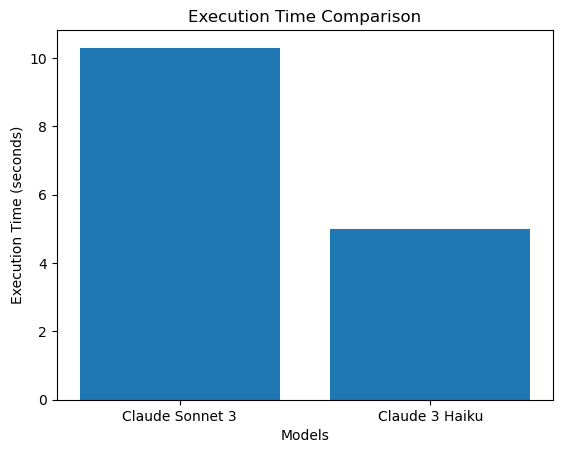

In [19]:
import matplotlib.pyplot as plt

exec_times = [execution_time, execution_time2]

plt.bar(["Claude Sonnet 3", "Claude 3 Haiku"], exec_times)
plt.xlabel("Models")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison")
plt.show()


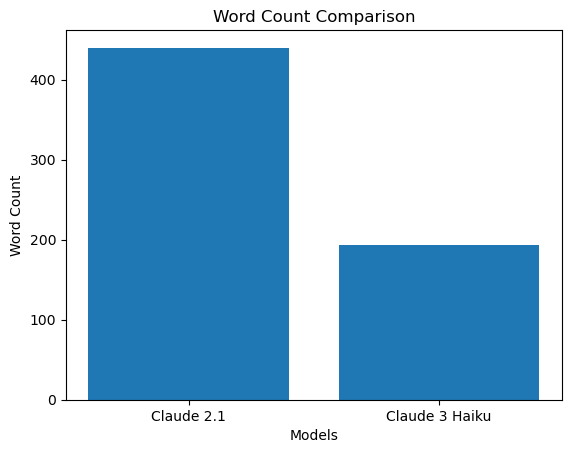

In [21]:
word_count_1 = len(response.content.split())
word_count_2 = len(response2.content.split())

plt.bar(["Claude 2.1", "Claude 3 Haiku"], [word_count_1, word_count_2])
plt.xlabel("Models")
plt.ylabel("Word Count")
plt.title("Word Count Comparison")
plt.show()


In [23]:
from textstat import flesch_reading_ease

readability_1 = flesch_reading_ease(response.content)
readability_2 = flesch_reading_ease(response2.content)

print("Readability Score for Claude 2.1:", readability_1)
print("Readability Score for Claude 3 Haiku:", readability_2)


Readability Score for Claude 2.1: -4.3831230529594905
Readability Score for Claude 3 Haiku: -22.249632107023388


In [24]:
response_multilingual = llm.invoke("Expliquez les tendances actuelles dans la fabrication industrielle.")
print("Claude 2.1 (French):", response_multilingual)


Claude 2.1 (French): content="Voici quelques tendances actuelles importantes dans la fabrication industrielle :\n\nL'automatisation et la robotique : L'utilisation de robots et de systèmes automatisés pour effectuer des tâches de production augmente considérablement. Cela permet d'accroître l'efficacité, la précision et la productivité tout en réduisant les coûts de main-d'œuvre.\n\nL'Internet des objets (IoT) : La connectivité des machines et des capteurs permet une collecte massive de données en temps réel sur les processus de production. Ces données peuvent être analysées pour optimiser les opérations.\n\nL'impression 3D : Les technologies d'impression 3D ou de fabrication additive se développent rapidement, permettant une production à la demande et sur mesure de pièces complexes.\n\nL'intelligence artificielle (IA) : L'IA est utilisée pour analyser les données, optimiser les processus, détecter les défauts et prédire les besoins de maintenance.\n\nLes usines intelligentes : Combina

In [25]:
prompt_with_examples = """
Example 1: What are the benefits of AI? -> AI enables automation and improves efficiency.
Example 2: Explain cloud computing. -> Cloud computing is the delivery of computing services over the internet.
Now, explain industrial manufacturing trends.
"""
response_few_shot = llm.invoke(prompt_with_examples)
print(response_few_shot)


content='Industrial manufacturing trends refer to the emerging technologies, processes, and practices that are shaping the future of manufacturing industries. Some notable industrial manufacturing trends include:\n\n1. Automation and robotics: The increasing adoption of automated systems, robots, and cobots (collaborative robots) to streamline production processes, improve efficiency, and reduce labor costs.\n\n2. Internet of Things (IoT) and connected factories: The integration of IoT devices, sensors, and interconnected systems to enable real-time data collection, monitoring, and analysis, leading to predictive maintenance, optimized operations, and improved decision-making.\n\n3. Additive manufacturing (3D printing): The use of additive manufacturing techniques, such as 3D printing, to produce complex parts and components directly from digital models, enabling customization, reducing waste, and shortening lead times.\n\n4. Advanced materials: The development and use of new and advan

In [26]:
long_prompt = "Write a detailed report on the impact of robotics in industrial manufacturing."
long_response = llm.invoke(long_prompt)
print(long_response)


content='Robotics has had a profound impact on industrial manufacturing, revolutionizing the way products are produced and assembled. The integration of robotic systems into manufacturing processes has brought about significant improvements in efficiency, quality, and productivity. Here is a detailed report on the impact of robotics in industrial manufacturing:\n\n1. Increased Productivity and Efficiency:\n   - Robots can work continuously without breaks, fatigue, or the need for rest, leading to higher production rates and output.\n   - Automated robotic systems can perform repetitive tasks with high precision and consistency, reducing errors and waste.\n   - Robots can operate at faster speeds than human workers, accelerating production cycles and throughput.\n\n2. Improved Quality and Consistency:\n   - Robotic systems are highly accurate and can perform tasks with exceptional repeatability, ensuring consistent quality across products.\n   - Robots eliminate human errors and variati